In [2]:
# If in colab, clone the repo and install the dependencies
if 'google.colab' in str(get_ipython()):
    !git clone https://github.com/alignment-research-center/low-probability-estimation.git
    import sys
    sys.path.insert(0,'low-probability-estimation')

    #install all packages in the install_requires of lpe
    !pip install fancy-einsum
    !pip install jaxtyping
    !pip install datasets
    !pip install blobfile
    
    !curl https://sdk.cloud.google.com | bash

In [1]:
import torch as th
import sys
import os
import matplotlib.pyplot as plt
from lpe.methods import QLD, GLD, ITGIS, MHIS
from lpe.method_utils import *
from lpe.utils import Transformer
from lpe.utils import datasets as lpe_datasets

In [3]:
model_name = "gelu-1l"
device = th.device("cuda" if th.cuda.is_available() else "cpu")
model = Transformer.from_pretrained(model_name).to(device)

config.json:   0%|          | 0.00/1.28k [00:00<?, ?B/s]

model_final.pth:   0%|          | 0.00/213M [00:00<?, ?B/s]

In [6]:
dist_name = "camel"
gt_freqs = load_ground_truth(model_name, [dist_name], device=device)[dist_name] # ground truth tensor
gt_probs = gt_freqs / gt_freqs.sum()
targets = pick_random_tokens(gt_freqs, 16, 1e-9, 1e-5)

In [7]:
## Uncomment this line to cache the dataset used to generate the distribution (recommended). It
##   will save the dataset in your default HuggingFace cache directory and speed up the next cell.
# lpe_datasets.USE_CACHE = True

# Generate 2^16 samples of the pre-unembed activations (used for QLD and GLD)
acts = gen_activ_samples(model, dist_name, n_samples=2**16, show_progress=True)

100%|██████████| 1024/1024 [00:01<00:00, 725.55it/s]


In [8]:
# Generate estimates
methods = ["QLD", "ITGIS", "MHIS"]
estimates = {}
orig_dists = distribution_registry[dist_name](model.tokenizer, device=model.device).input_dists(n_reps=N_REPS_DICT[dist_name])
for method in methods:
    print(f"Computing estimates for {method}")
    estimates[method] = {}
    for target in tqdm(list(targets)):
        if method == "QLD":
            estimates[method][target] = QLD(model.unembed.W_U, acts, target)
        elif method == "ITGIS":
            estimates[method][target] = ITGIS(model, orig_dists, target, temp=RECOMMENDED_TEMPS[model_name]["ITGIS"][dist_name], n_samples=2**16)
        elif method == "MHIS":
            estimates[method][target] = MHIS(model, orig_dists, target, temp=RECOMMENDED_TEMPS[model_name]["MHIS"][dist_name], n_samples=2**16, burn_in=2**10)

Computing estimates for QLD


100%|██████████| 16/16 [00:04<00:00,  3.22it/s]


Computing estimates for ITGIS


100%|██████████| 16/16 [04:05<00:00, 15.36s/it]


Computing estimates for MHIS


100%|██████████| 16/16 [08:33<00:00, 32.12s/it]


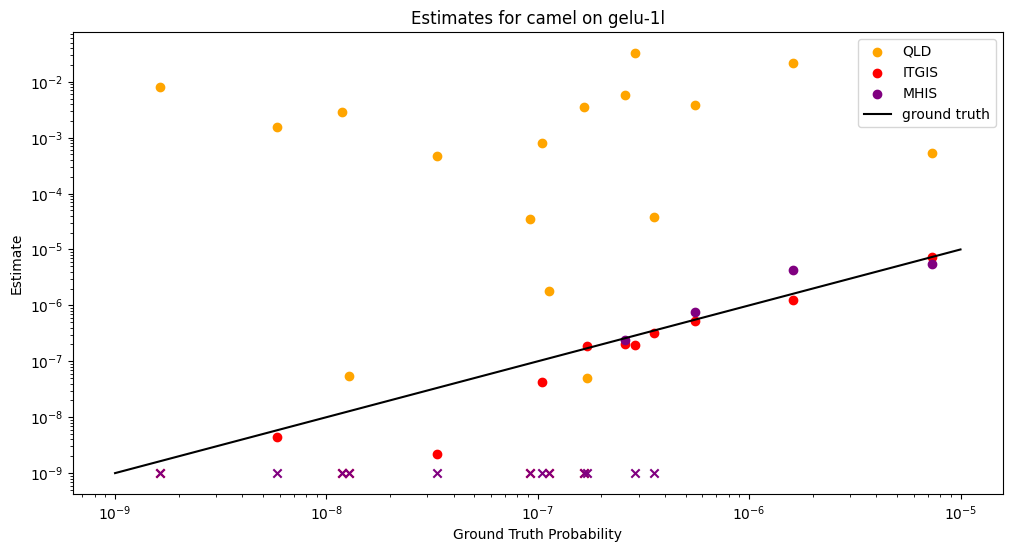

In [9]:
# Plot the (unfit) estimates
plt.figure(figsize=(12, 6))
colors = {'QLD': 'orange', 'ITGIS': 'red', 'MHIS': 'purple'}
for method in methods:
    estimates_for_method = [estimates[method][target] for target in targets]
    plt.scatter(gt_probs[targets].cpu().numpy(), estimates_for_method, label=method, color=colors[method])

    # Plot the 0s at the bottom
    zero_targets = list(filter(lambda target: estimates[method][target] == 0, targets))
    plt.scatter(gt_probs[zero_targets].cpu().numpy(), [1e-9]*len(zero_targets), color=colors[method], marker='x')


plt.plot([1e-9, 1e-5], [1e-9, 1e-5], label='ground truth', color='black')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Ground Truth Probability')
plt.ylabel('Estimate')
plt.title(f"Estimates for {dist_name} on {model_name}")
plt.legend()
plt.show()